In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

# from sim_engine import Scale_model
# from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
# from spec_stats import Smooth, Highest_density_region
# from spec_id import *
# from spec_exam import Gen_spec

from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline



Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
### generate intial multibeam object

def Gen_initial_MB(Beam_location, gid):
    # get beam list
    fl = glob('{}/*{}*'.format(Beam_location,gid))

    # remove repeats
    nlist = []
    blist = []
    for f in fl:
        mb = multifit.MultiBeam(f,**args)
        for bm in mb.beams:
            if bm.grism.parent_file not in nlist:
                nlist.append(bm.grism.parent_file)
                blist.append(bm)
    
    #make the mb
    mb = multifit.MultiBeam(blist,**args)

    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb


### plot stacked grism spectra

def Plot_grism(MB, ax, color,instr, lims):
    sptbl = MB.oned_spectrum()

    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
        
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

    ax.errorbar(w[clip],f[clip]/fl[clip],e[clip]/fl[clip], color = color,
                linestyle='None', marker='o', markersize=0.25, zorder = 1, elinewidth = 1)

#### plot the individual beams
    
def Plot_beams(mb):#,W,P,E):
    gs = gridspec.GridSpec(2,2)

    plt.figure(figsize=[20,12])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

        if bm.grism.filter == 'G102':
            IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
            ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
        else:
            IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
            ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 
    
    ax = plt.subplot(gs[1,:])
    try:
        Plot_grism(mb , ax, 'b', 'G102', [8000,11500])
    except:
        pass
    try:
        Plot_grism(mb , ax, 'r', 'G141', [11000,16500])
    except:
        pass
    
#     IDP = [U for U in range(len(W)) if P[U]/E[U]  > 0.05]

    
#     ax.errorbar(np.array(W)[IDP],np.array(P)[IDP],np.array(E)[IDP], fmt='o', color='k', zorder=0)
#     ax.set_xscale('log')    
    
def Beam_cleanup(mb, B_condition=[], R_condition=[]):
    ## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
    Bselect = False
    Rselect = False
    
    if len(B_condition) == 5:
        Bwvl, Bwvh, B_cond, Bfl, B_cl = B_condition
        Bselect = True

    if len(R_condition) == 5:
        Rwvl, Rwvh, R_cond, Rfl, R_cl = R_condition
        Rselect = True

    BEAM_exempt =[]
    ids = 0
    cleanspec = []
    clip_lims = []
    ### selection for bad beams
    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)
        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)
        bex = False

        if Bselect:
            for i in range(len(xspec)):
                if B_cond == 'gtr':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) > Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break

                if B_cond == 'less':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) < Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break
        
        if Rselect:
            for i in range(len(xspec)):
                if R_cond == 'gtr':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) > Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

                if R_cond == 'less':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) < Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

        if bex:
            BEAM_exempt.append(bm.grism.parent_file)

    ### set up selection settings
    
    omitspec = np.zeros(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
    for i in range(len(cleanspec)):
        if cleanspec[i] == 'clip':
            clipspec[i] = 1
            
        if cleanspec[i] == 'omit':
            omitspec[i] = 1   
    return BEAM_exempt, clip_lims, clipspec, omitspec
            
def Clean_mb(mb, BEAM_exempt, clip_lims, clipspec, omitspec):   
    fblist = []
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:            
            if clipspec[idc] == 1:
                xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
                lms = clip_lims[idc]
                for i in range(len(xspec)):
                    if lms[0] < xspec[i]< lms[1]:
                        bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                        bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000  

            if omitspec[idc] == 1:
                pass
            else:    
                fblist.append(bm)

            idc += 1

        else:    
            fblist.append(bm)   

    mb = multifit.MultiBeam(fblist,**args)
    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

# def Phot_load(field, galaxy_id,ref_cat_loc,masterlist = '../phot/master_template_list.pkl'):
#     galdf = ref_cat_loc[ref_cat_loc.id == galaxy_id]
#     master_tmp_df = pd.read_pickle(masterlist)

#     if field == 'GSD':
#         pre= 'S_'

#     if field == 'GND':
#         pre= 'N_'

#     eff_wv = []
#     phot_fl = []
#     phot_er = []
#     phot_num = []

#     for i in galdf.keys():
#         if i[0:2] == 'f_':
#             Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
#             if galdf[i].values[0] > -99.0:
#                 eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
#                 phot_fl.append(galdf[i].values[0]*Clam)
#                 phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
#         if i[0:2] == 'e_':
#             if galdf[i].values[0] > -99.0:
#                 phot_er.append(galdf[i].values[0]*Clam)
    
#     return eff_wv, phot_fl, phot_er

In [4]:
temps = {}
for k in args['t1']:
    if k[0] == 'f' or k[5:] in ['Ha', 'Hb', 'Hg', 'Hd'] :
        temps[k] = args['t1'][k]

In [44]:
gid = 46130

# rshift = cat.query('id == {}'.format(gid)).z_50.values[0] 

mb  = Gen_initial_MB(Beam_location, gid)

load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GS3/GS3_46130.beams.fits
1 ibhj11hiq_flt.fits G141
2 ibhj11hpq_flt.fits G141
3 ibhj11hwq_flt.fits G141
4 ibhj11i3q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1585: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)


load_master_fits: /Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/GS2/GS2_46130.beams.fits
1 ibhj11hiq_flt.fits G141
2 ibhj11hpq_flt.fits G141
3 ibhj11hwq_flt.fits G141
4 ibhj11i3q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3596: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 ibhj03xoq_flt.fits G141
6 ibhj03xvq_flt.fits G141
7 ibhj03y2q_flt.fits G141
8 ibhj03y9q_flt.fits G141
9 icxt01ciq_flt.fits G102
10 icxt01clq_flt.fits G102
11 icxt01cnq_flt.fits G102
12 icxt02caq_flt.fits G102
13 icxt02cdq_flt.fits G102
14 icxt02cfq_flt.fits G102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:640: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:641: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


['icxt01ciq_flt.fits']
[[9500, 10000]] [0.]
[1.]


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1585: RuntimeWarning: divide by zero encountered in true_divide
  ivar = 1./(1/b.ivar + (self.sys_err*sciu)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3596: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-1.0.dev1443-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:590: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


S 46130 2.314024837528427


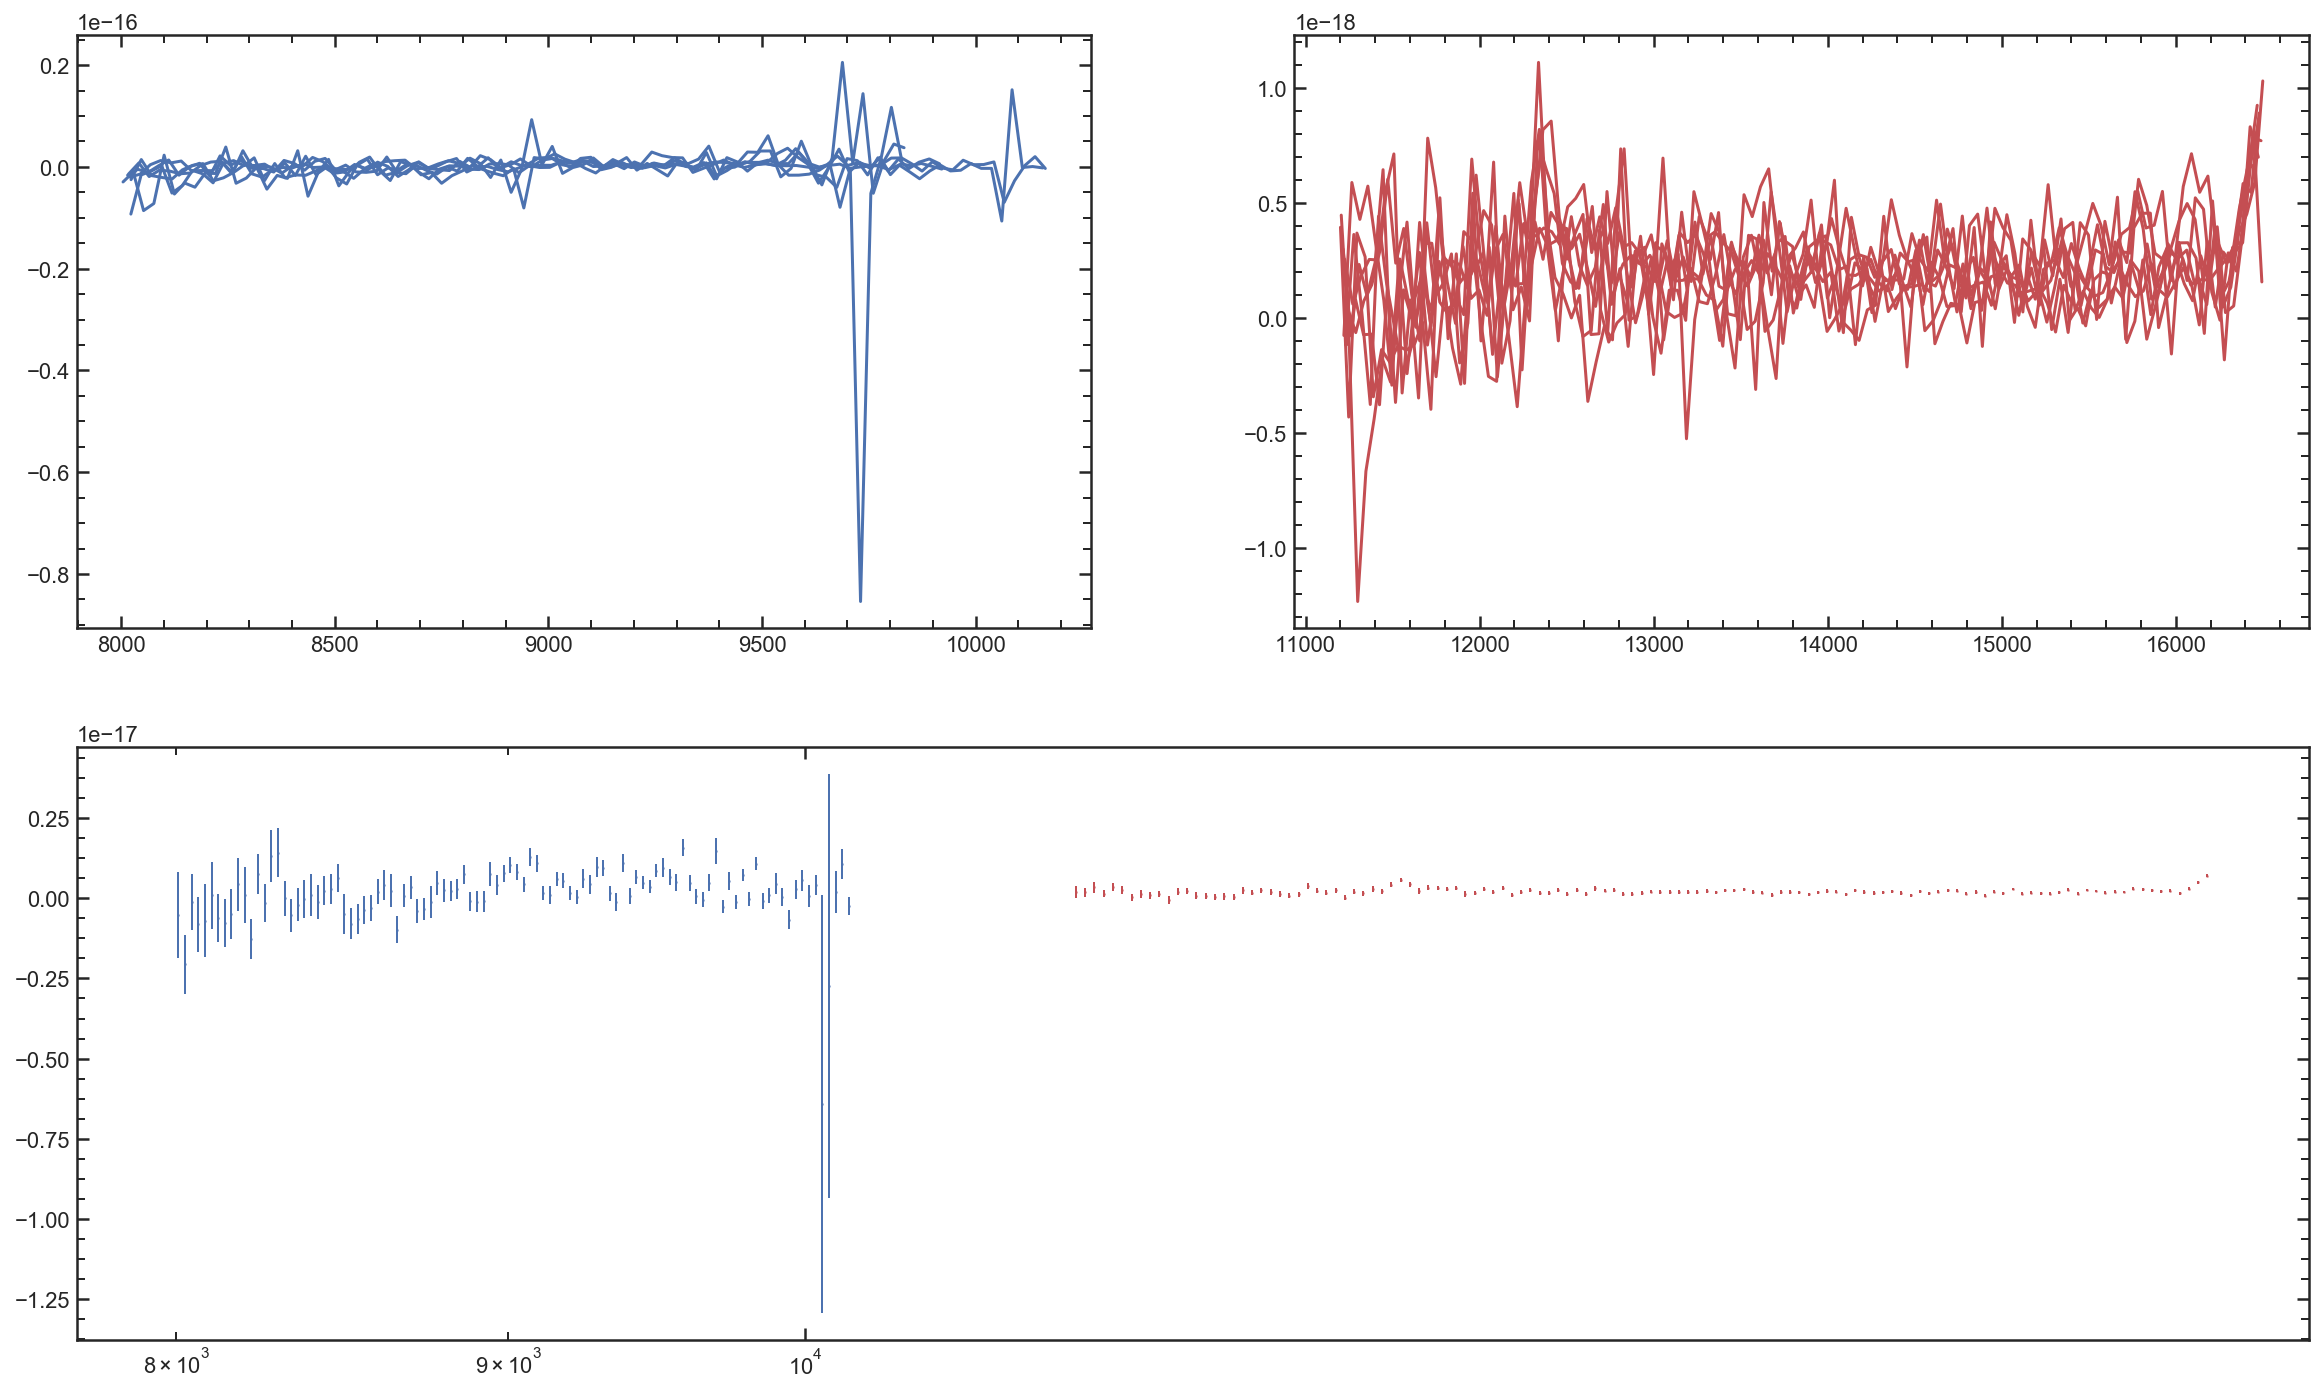

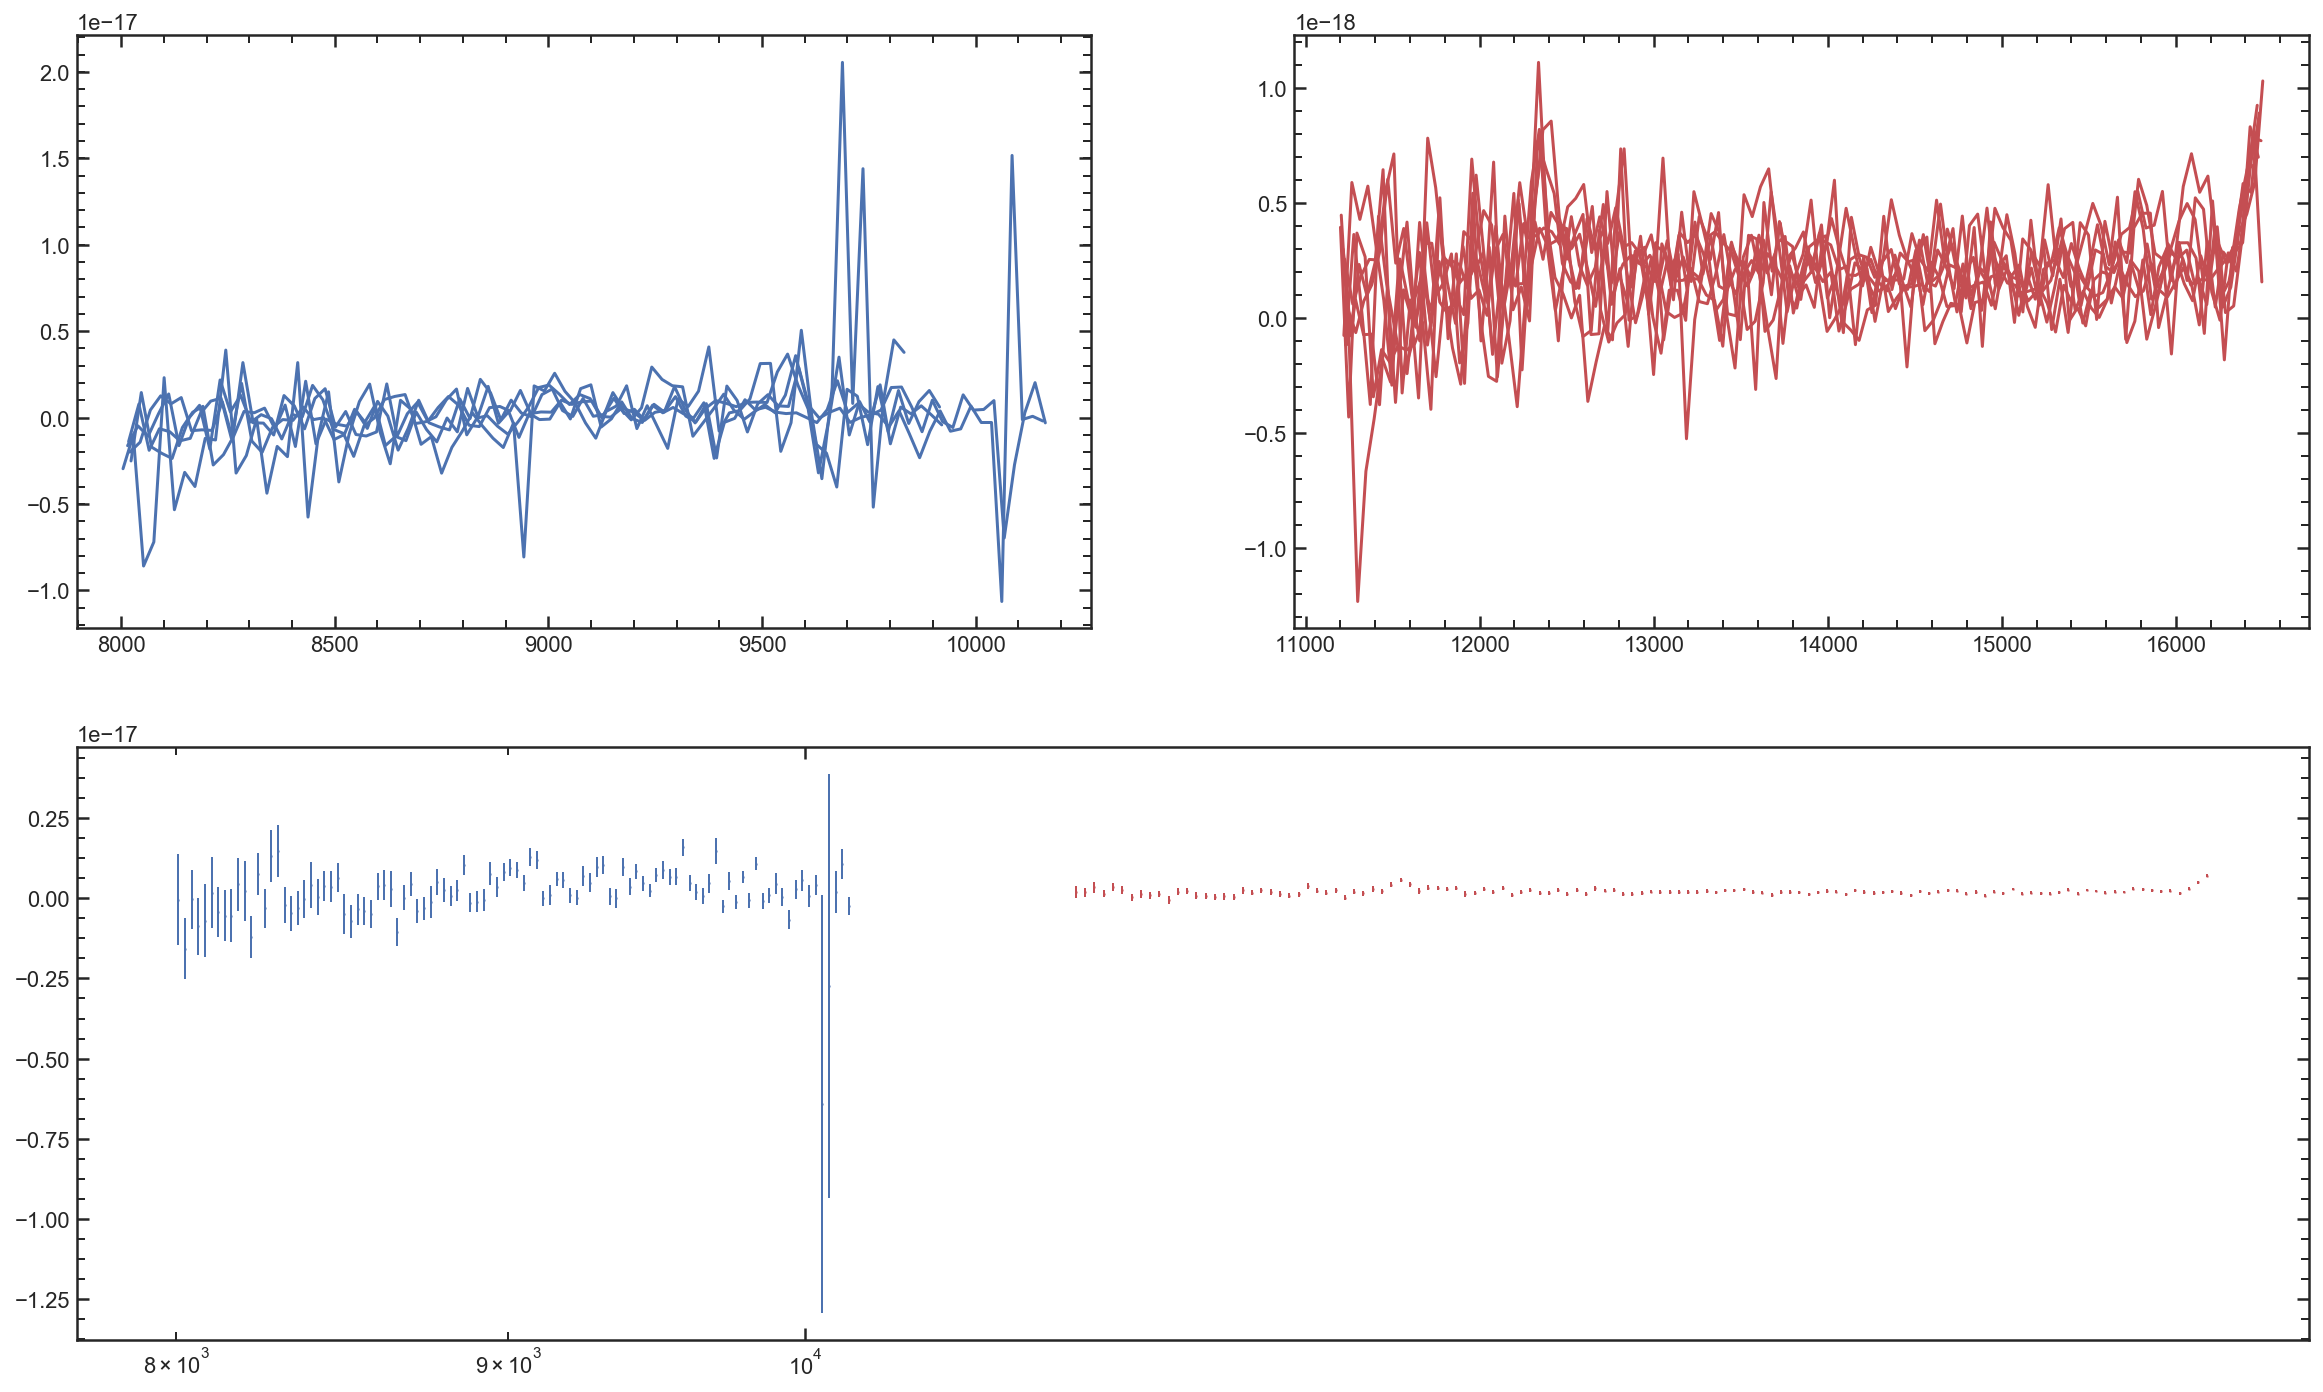

In [45]:
## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
Plot_beams(mb)#,W,P,E)
BMX, Clims, Cspec, Ospec = Beam_cleanup(mb, B_condition=[9500, 10000, 'less', -0.5E-16, 'omit'], R_condition=[])
print(BMX)
print(Clims, Cspec)
print(Ospec)

MB = Clean_mb(mb, BMX, np.array(Clims), Cspec, Ospec)
Plot_beams(MB)#,W,P,E)

# np.save('../beams/beam_config/G{}D_{}_ex'.format(field, gid),[BMX])
# np.save('../beams/beam_config/G{}D_{}'.format(field, gid),[Clims, Cspec, Ospec])

print(field, gid, rshift)